# Diabetes Prediction – Pima Indians Dataset - End-to-End ML (Portfolio)

**Goal:** Predict whether a person has diabetes (Outcome = 1) based on medical measurements.

**Dataset:**: [Pima Indians Diabetes Database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)


**What this notebook covers**
* Import libraries & load data  
* Clean impossible values (0 → NaN)  
* Split data (train/test)  
* Build and train models  
* Evaluate metrics (Accuracy, Precision, Recall, F1, ROC-AUC)  
* Visualize confusion matrix & ROC curve  
* Interpret feature importance  
* Save model & plots

**Tech stack:** Python · pandas · scikit-learn · matplotlib/seaborn

## 1. Import libraries and load data
We start by importing the main data analysis and visualization libraries (pandas, numpy, seaborn, matplotlib) and loading the Diabetes dataset. The goal is to predict who will have diabetes.

In [34]:
# Basic tools for Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine Learning Tools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay)

import joblib

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# Load data
import os, pathlib
PROJECT_DIR = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Pima Indians Diabetes Project").resolve()
DATA_DIR = PROJECT_DIR
MODELS_DIR = PROJECT_DIR / "models"
IMAGES_DIR = PROJECT_DIR / "images"
MODELS_DIR.mkdir(exist_ok=True); IMAGES_DIR.mkdir(exist_ok=True)

TRAIN_PATH = DATA_DIR / "diabetes.csv"

In [37]:
# Define the function
def load_data(path):
    print(f"Loading data from: {path}")
    df = pd.read_csv(path)
    print(f"Loaded {df.shape[0]} rows and {df.shape[1]} columns.")
    display(df.head())
    return df

# Use the function to load the dataset
df = load_data(TRAIN_PATH)

Loading data from: /content/drive/MyDrive/Colab Notebooks/Pima Indians Diabetes Project/diabetes.csv
Loaded 768 rows and 9 columns.


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Target = Outcome (1 = diabetes, 0 = healthy).

Features = all other columns.

## 2. Data Understanding

In [38]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [39]:
# Check null
df.isna().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


These columns can’t realistically be zero (like “Glucose = 0”),
so we mark them as missing (NaN) to fill later.

In [40]:
# Replace zero's with NaN
cols_to_fix = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[cols_to_fix] = df[cols_to_fix].replace(0, np.nan)
df.isna().sum()

,0
Pregnancies,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


## 3. Split features and Target

In [41]:
X = df.drop(columns = ["Outcome"])
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify = y)

print("Training shape: ", X_train.shape)
print("Test shape: ", X_test.shape)
print("Target ratio (train): ", y_train.mean().round(3) )
print("Target ratio (test): ", y_test.mean().round(3) )

Training shape:  (614, 8)
Test shape:  (154, 8)
Target ratio (train):  0.349
Target ratio (test):  0.351


We reserve 20 % of the data for testing.
`stratify=y` keeps the same ratio of diabetic/non-diabetic cases in both sets.

# 4. Build models

In [42]:
def build_models():
    logreg = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000))
    ])

    tree_clf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", DecisionTreeClassifier(max_depth=4, random_state=42))
    ])

    rf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", RandomForestClassifier(n_estimators=400, random_state=42))
    ])

    return {
        "Logistic Regression": logreg,
        "Decision Tree (depth=4)": tree_clf,
        "Random Forest": rf
    }

models = build_models()

* Imputer for fills missing values

* Scaler (for Logistic Regression only) scales data

* Model learns the pattern

## 5. Fit Models

In [43]:
fitted = {name: model.fit(X_train, y_train) for name, model in models.items()}

Models are trained.

## 6. Evaluate Models

In [44]:
def evaluate(model, name):
  y_pred = model.predict(X_test)
  y_proba = model.predict_proba(X_test)[:,1]
  return{
      "Model": name,
      "Accuracy": accuracy_score(y_test, y_pred),
      "Precision": precision_score(y_test, y_pred),
      "Recall": recall_score(y_test, y_pred),
      "F1": f1_score(y_test, y_pred),
      "ROC-AUC": roc_auc_score(y_test, y_proba)
  }

results = pd.DataFrame([
    evaluate(model, name) for name, model in fitted.items()
]).round(3).sort_values("ROC-AUC", ascending=False)

display(results)

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
2,Random Forest,0.740,0.659,0.537,0.592,0.816
0,Logistic Regression,0.708,0.600,0.500,0.545,0.813
1,Decision Tree (depth=4),0.786,0.698,0.685,0.692,0.789


## 7. Confusion Matrix & ROC Curve

Best model: Random Forest


<Figure size 600x600 with 0 Axes>

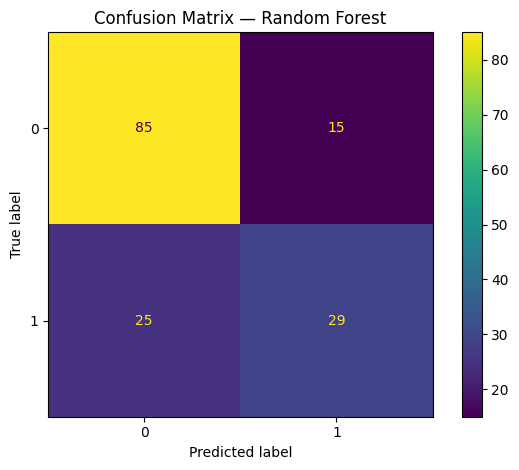

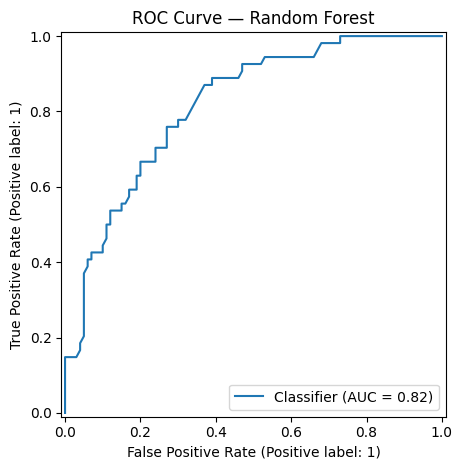

In [45]:
best_name = results.iloc[0]["Model"]
best = fitted[best_name]
print("Best model:", best_name)

y_proba = best.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

plt.figure(figsize=(6,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f"Confusion Matrix — {best_name}")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title(f"ROC Curve — {best_name}")
plt.tight_layout()
plt.show()

**Confusion Matrix Results:**

*   True Negative (TN): Healthy correctly predicted healthy = 85
*   False Positive (FP): Healthy predicted as diabetic = 15
*   False Negative (FN):	Diabetic predicted as healthy = 25
*   True Positive (TP):	Diabetic correctly predicted diabetic = 29


The **ROC-AUC** = 0.82 indicates good discrimination ability = the model correctly ranks diabetic vs. non-diabetic patients most of the time.

The model achieved good balance: 114/154 correct, AUC = 0.82.
It detects most diabetic cases but misses 25 of them; tuning the decision threshold could improve recall.

## 8. Threshold Tuning (F1 Optimization)

Best threshold: 0.28 | Best F1: 0.681


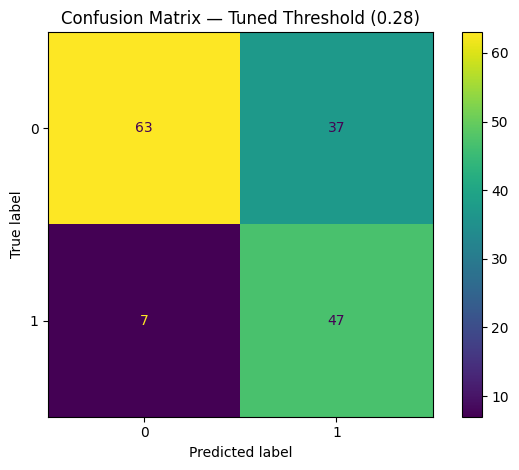

In [46]:
best_thr, best_f1 = 0.5, -1
for thr in np.linspace(0.2, 0.8, 25):
    pred = (y_proba >= thr).astype(int)
    f1 = f1_score(y_test, pred)
    if f1 > best_f1:
        best_thr, best_f1 = thr, f1

print(f"Best threshold: {best_thr:.2f} | Best F1: {best_f1:.3f}")

# Visualize confusion matrix at tuned threshold
pred_tuned = (y_proba >= best_thr).astype(int)
ConfusionMatrixDisplay.from_predictions(y_test, pred_tuned)
plt.title(f"Confusion Matrix — Tuned Threshold ({best_thr:.2f})")
plt.tight_layout()
plt.show()

## 9. Decision Tree Diagram

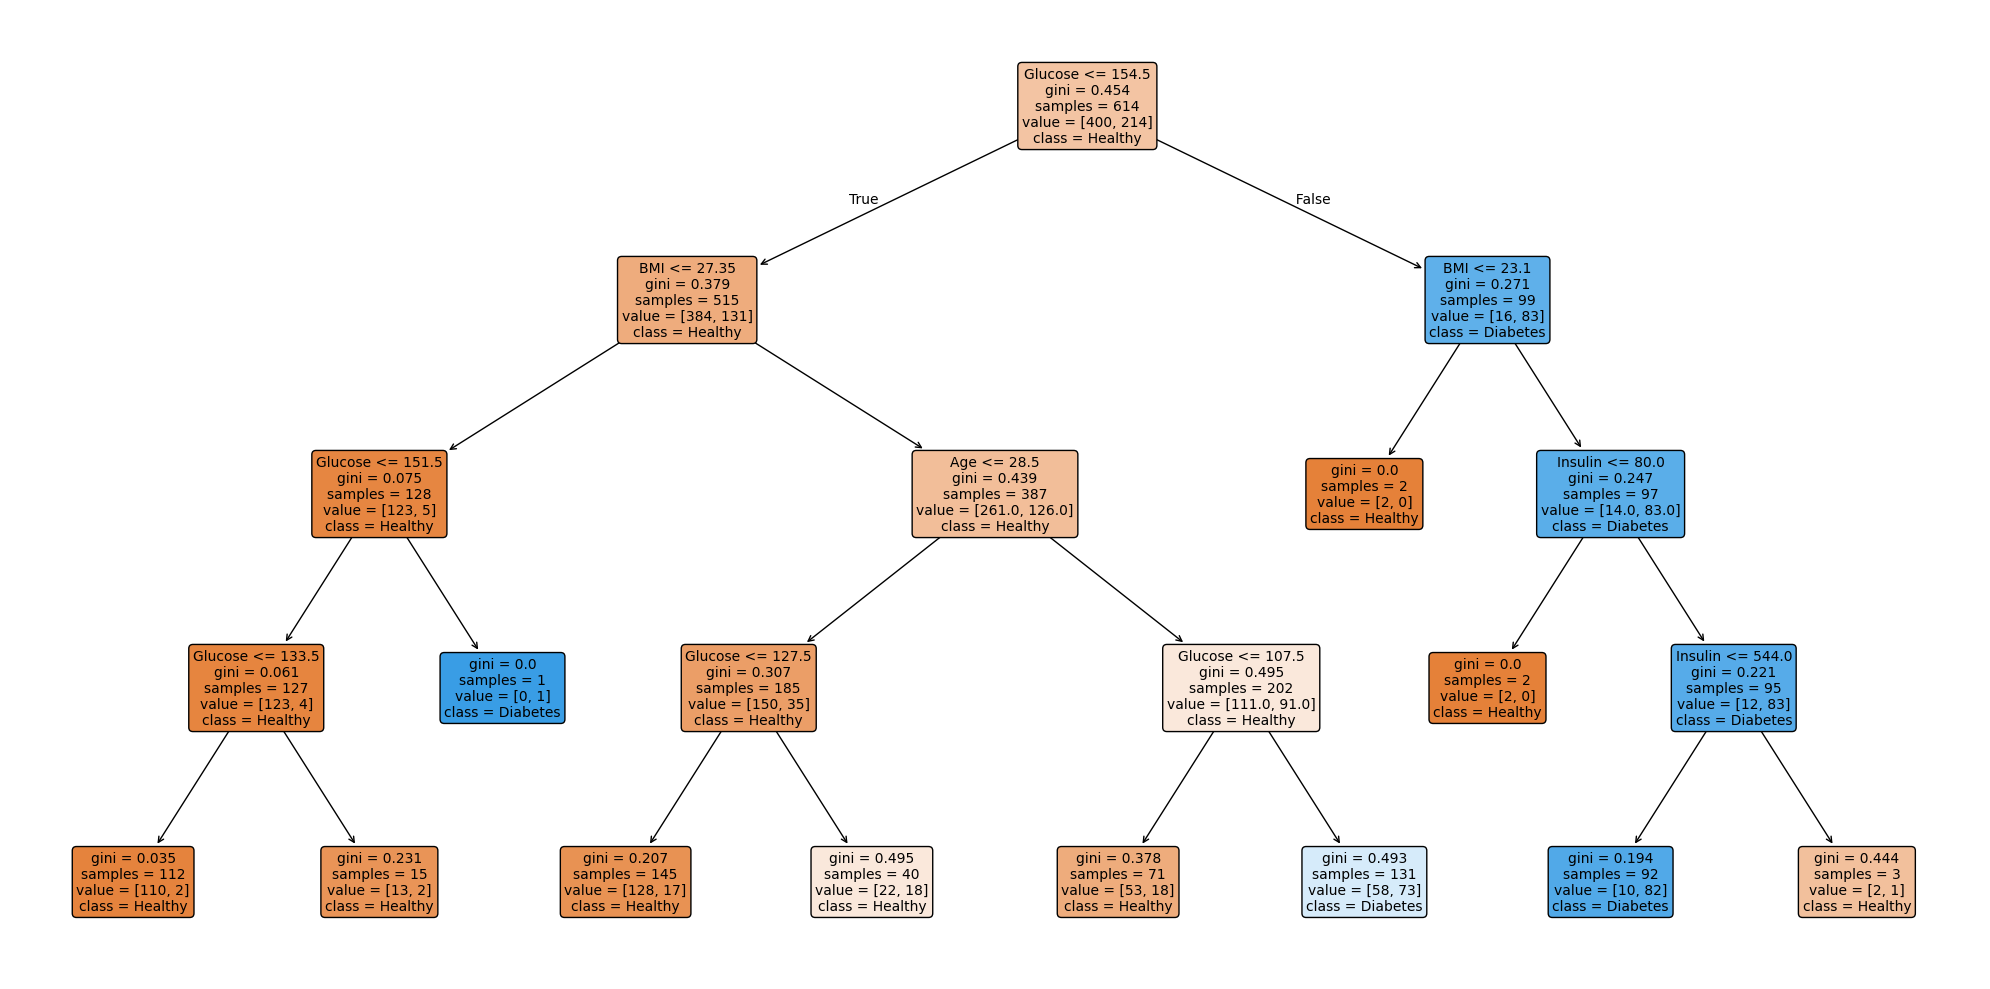

In [47]:
inner_tree = fitted["Decision Tree (depth=4)"].named_steps["model"]

plt.figure(figsize=(20,10))
plot_tree(inner_tree,
          feature_names=X_train.columns,
          class_names=["Healthy", "Diabetes"],
          filled=True, rounded=True, fontsize=10)
plt.tight_layout()
plt.show()

## 10. Permutation Importance

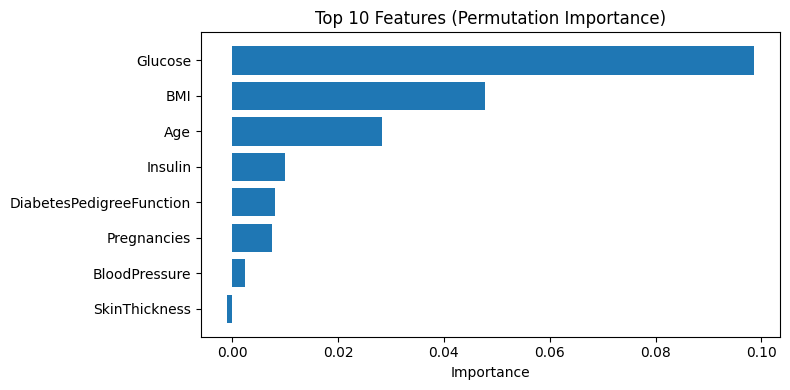

In [48]:
from sklearn.inspection import permutation_importance
pi = permutation_importance(best, X_test, y_test, n_repeats=20,
                            random_state=42, scoring="roc_auc")

imp = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": pi.importances_mean
}).sort_values("Importance", ascending=False).reset_index(drop=True)

plt.figure(figsize=(8,4))
plt.barh(imp["Feature"].head(10), imp["Importance"].head(10))
plt.gca().invert_yaxis()
plt.title("Top 10 Features (Permutation Importance)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## 11. Saving

Saved: /content/drive/MyDrive/Colab Notebooks/Pima Indians Diabetes Project/models/diabetes_best_model.joblib


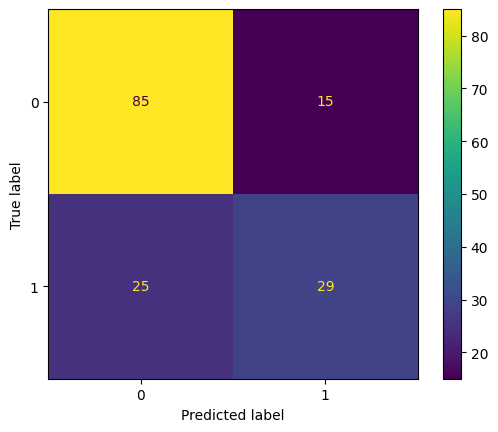

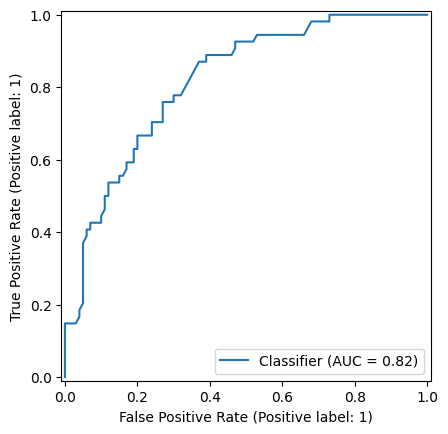

In [49]:
# Save best model
model_path = MODELS_DIR / "diabetes_best_model.joblib"
joblib.dump(best, model_path)

# Save plots
fig = ConfusionMatrixDisplay.from_predictions(y_test, y_pred).figure_
fig.savefig(IMAGES_DIR / "confusion_matrix.png", dpi=160, bbox_inches="tight")

fig = RocCurveDisplay.from_predictions(y_test, y_proba).figure_
fig.savefig(IMAGES_DIR / "roc_curve.png", dpi=160, bbox_inches="tight")

print("Saved:", model_path)

## 12. Final Summary

In [50]:
summary = results.sort_values("ROC-AUC", ascending=False).reset_index(drop=True)
print("Summary")
print("Target: Outcome (1=Diabetes)")
print("Train/Test:", X_train.shape, X_test.shape)
print("\nLeaderboard:\n", summary)
print("\nPermutation Importance (top 10):")
display(imp.head(10))
print("\nModel saved to:", model_path)

Summary
Target: Outcome (1=Diabetes)
Train/Test: (614, 8) (154, 8)

Leaderboard:
                      Model  Accuracy  Precision  Recall     F1  ROC-AUC
0            Random Forest     0.740      0.659   0.537  0.592    0.816
1      Logistic Regression     0.708      0.600   0.500  0.545    0.813
2  Decision Tree (depth=4)     0.786      0.698   0.685  0.692    0.789

Permutation Importance (top 10):


,Feature,Importance
0,Glucose,0.098546
1,BMI,0.047694
2,Age,0.028375
3,Insulin,0.009954
4,DiabetesPedigreeFunction,0.008139
5,Pregnancies,0.007556
6,BloodPressure,0.002519
7,SkinThickness,-0.000907



Model saved to: /content/drive/MyDrive/Colab Notebooks/Pima Indians Diabetes Project/models/diabetes_best_model.joblib


From the results, the `Random Forest` model has the highest `ROC-AUC` of **0.816**, followed closely by `Logistic Regression` (**0.813**). The `Decision Tree` (depth = 4) has the highest Accuracy and F1 score, but a slightly lower ROC-AUC compared to `Random Forest` and `Logistic Regression`. This suggests that while Decision Tree has good overall correct predictions and a good balance of precision and recall, `Random Forest` and `Logistic Regression` are slightly better at ranking positive cases higher than negative cases.

## 13. Environment Info

In [51]:
import sys, sklearn
print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__, "| numpy:", np.__version__,
      "| sklearn:", sklearn.__version__, "| matplotlib:", plt.matplotlib.__version__)

Python: 3.12.12
pandas: 2.2.2 | numpy: 2.0.2 | sklearn: 1.6.1 | matplotlib: 3.10.0
